In [14]:
import numpy as np
import pandas as pd
import re as re
from langdetect import detect
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
from PIL import Image
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns



In [15]:
#Part 1 - Simple Wordcloud

In [16]:
# read in translated + cleaned data


df_clean = pd.read_csv("18_march_df_cleaned_translated_abstracts.csv")
df_clean_no_stem = pd.read_csv("18_march_df_clean_translate_nostem.csv")

In [17]:
def wordcloud_maker(df_new):
    df_new.abstract.astype(str)  #abstract to string
    df_new.foundation.astype(str) #abstract to string
    df_cleaned = df_new.dropna(subset = ["cleaned_column"]) #drop NA
    df_grouped = df_cleaned.groupby("foundation", as_index=False).agg({"cleaned_column": " ".join})  #group by foundation and join ALL abstracts for each foundation

    print(df_grouped.foundation)
    carlsberg_text = df_grouped.cleaned_column.iloc[0]
    IDRF = df_grouped.cleaned_column.iloc[1]
    novo = df_grouped.cleaned_column.iloc[2]

    # wordclouds:

    # Carlsberg
    
    print("Carlsberg")
    wc = WordCloud().generate(carlsberg_text)
    plt.imshow(wc)
    plt.show()
    
    print("Independent Research Fund Denmark")
    wc = WordCloud().generate(IDRF)
    plt.imshow(wc)
    plt.show()
    
    print("Novo Nordisk Foundation")
    wc = WordCloud().generate(novo)
    plt.imshow(wc)
    plt.show()
    
    return


In [18]:
print("Foundations in dataset :")
print(df_clean.foundation.unique())

Foundations in dataset :
['Independent Research Fund Denmark' 'Carlsberg Foundation'
 'Novo Nordisk Foundation']


0                 Carlsberg Foundation
1    Independent Research Fund Denmark
2              Novo Nordisk Foundation
Name: foundation, dtype: object
Carlsberg


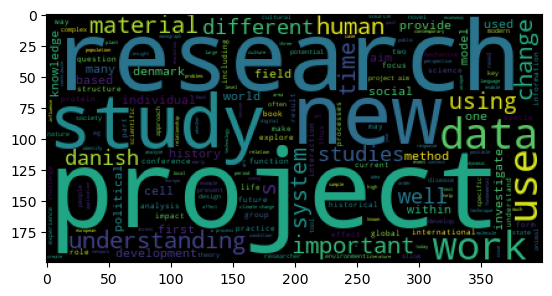

Independent Research Fund Denmark


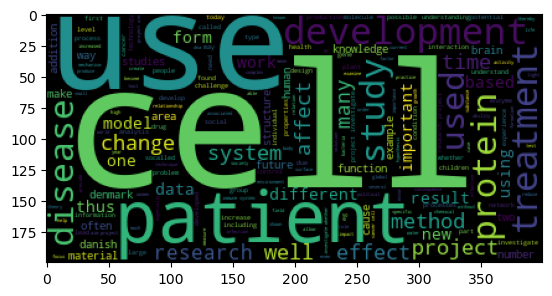

Novo Nordisk Foundation


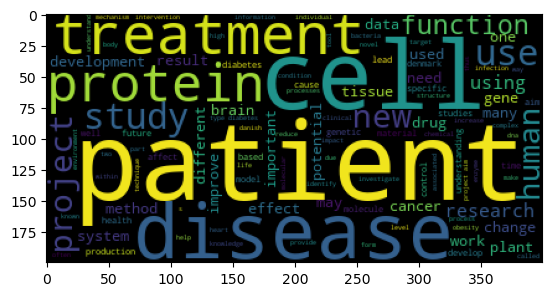

In [19]:
wordcloud_maker(df_clean)

0                 Carlsberg Foundation
1    Independent Research Fund Denmark
2              Novo Nordisk Foundation
Name: foundation, dtype: object
Carlsberg


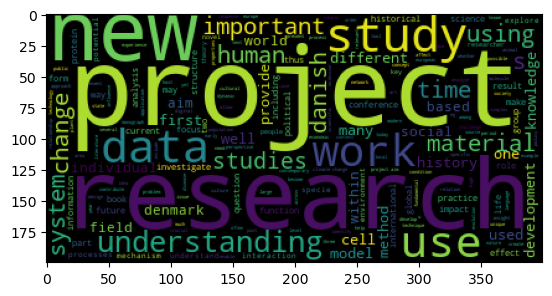

Independent Research Fund Denmark


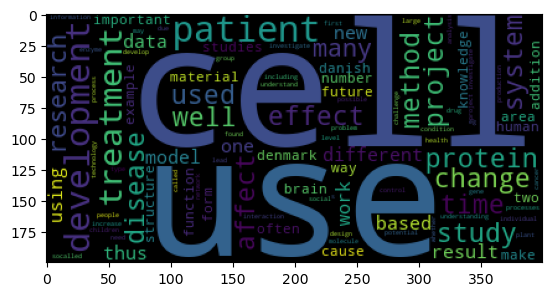

Novo Nordisk Foundation


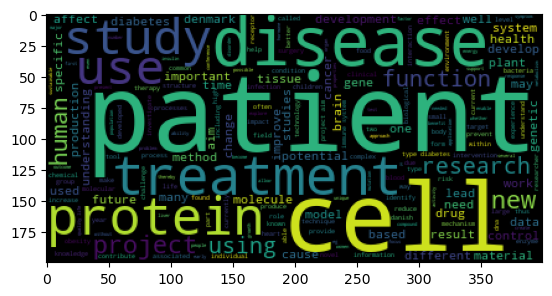

In [20]:
wordcloud_maker(df_clean_no_stem)

In [21]:
#Part 2 - PCA

In [33]:


def tf_idf_transform(df_target_column, min_ins, max_ins):
    
    df_target_column = df_target_column.fillna('')
    tf = TfidfVectorizer(tokenizer=casual_tokenize, min_df = min_ins, max_df = max_ins, stop_words='english', norm = "l2") #tf-idf tokenize init
    x_vector = tf.fit_transform(df_target_column)  # transform data
    number_of_features = len(tf.get_feature_names_out())
    
    print(number_of_features)
    print(tf.get_feature_names_out())
    
    return x_vector, number_of_features, tf


def find_variance(svd_init):
    
    cumulative_variance = np.cumsum(svd_init.explained_variance_ratio_)
    n_compon = np.argmax(cumulative_variance >= 0.9) + 1
    
    return n_compon
    

def plot_variance_and_cummulative(svd_init, n_feat):
    
    """
    Part 1: Explained Variance Plot
    
    Part 2: Cumulative Variance Plot
    
    """
    
    #Part 1
    
    explained_variance = svd_init.explained_variance_
    
    
    plt.figure(figsize=(10, 6))

    plt.plot(range(1, len(explained_variance) + 1), 
             explained_variance*100, # explained variance to percentage convertion
             marker='o', # each value marked
            )

    plt.title('Explained Variance for SVD Components')
    plt.xlabel('SVD Component')
    plt.ylabel('Explained Variance (in %)')


    plt.xticks(range(1, len(explained_variance) + 1, 5))

    plt.grid(True)

    plt.show()
    
    #Part 2
    
    plt.plot(np.cumsum(svd_init.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    plt.show()
    
    print("Explained variance of all components summed (%):")
    print(svd_init.explained_variance_ratio_[:n_feat].sum()*100)
    
    
    return 


def optimal_feature_number_prerun1(df_i, df_clean_abstract_col, min_num, max_num):
    

    X_vector, N_features, tf = tf_idf_transform(df_clean_abstract_col, min_num, max_num)  #tf_idf function


    #1. finding optimal component number
    svd2 = TruncatedSVD(N_features)


    svd2.fit_transform(X_vector)  #pca fit_tranform vector

    n_componen = find_variance(svd2)

    return n_componen, X_vector, N_features
    

def svd_calc(df_i, df_target_text_column, df_foundation_column, opt_number, X_vector, N_features):
    
    """
    SVD analysis and plotting:
    
    input: 
    1. the data with targeted text entries (abstract/title)
    2. foundation name of each text entry
    
    plots 
    
    1. variance explained 
    2. cumulative variance 
    3. SVD projection with k-means cluster in color 
    4. SVD projection with foundation in color 
    
    """

    #opt_number, X_vector, N_features = optimal_feature_number_prerun1(df_i, df_target_text_column, 0.05, 0.7)
    
    
    #n_components = min(N_features, X_vector.shape[1])  # Ensure it does not exceed available features
    
    
    #finding optimal component number
    #svd2 = TruncatedSVD(N_features)
    #svd2.fit_transform(X_vector)  #pca fit_tranform vector
    
    
    #svd_vec_scaled = StandardScaler(with_mean=True, with_std=False).fit_transform(svd_vec)  #scalong to zero
    
    
    svd = TruncatedSVD(n_components=opt_number, random_state=42)
    
    
    svd_real_vec = svd.fit_transform(X_vector)  #pca fit_tranform vector
    
    svd_real_vec = StandardScaler(with_mean=True, with_std=False).fit_transform(svd_real_vec)  #scalong to zero
    
    
    plot_variance_and_cummulative(svd, opt_number)  # plot function run
    
    #df_svd = pd.DataFrame(svd_vec, columns=list(range(N_features)))  # new dataframe of scaled numbers
    
    df_svd = pd.DataFrame(svd_real_vec, columns=list(range(svd_real_vec.shape[1])))  #svd initialization
    
    
    n_foundation = len(df_foundation_column.unique())
    
    
    print("data shape :", df_svd.shape)
    
    svd_new_df = pd.concat([df_svd, df_foundation_column.reset_index(drop=True)], axis=1)
    
    mean_values = svd_new_df.groupby('foundation')[[1, 2]].mean().reset_index()
    
    print(mean_values)
    
    #hue_order = [svd_new_df['foundation'].unique]
    
    order = svd_new_df.foundation.unique()
    
    sns.scatterplot(data=svd_new_df, x=1, y=2, hue="foundation", hue_order=order, palette="tab10", alpha = 0.5)
    
    sns.scatterplot( data = mean_values, x=1, y=2, hue="foundation", hue_order=order, palette="tab10", marker="X", s=100, legend=False)
    
    plt.ylim(-0.5, 0.5)
    plt.xlim(-0.5, 0.5)
    
    plt.title("Foundation Categories")

    plt.show()
    
    return

def optimal_feature_number_prerun(df_i, df_clean_abstract_col):
    

    #df_i["abstract_no_nan"] = df_clean_abstract_col.fillna('')

    #col_t = df_i["abstract_no_nan"]
    opt_num_of_features = []

    df_i = df_i.sort_values(["year"])

    X_vector, N_features, tf = tf_idf_transform(df_clean_abstract_col, 0.01, 0.9)  #tf_idf function

    df_i["year"] = df_i["year"].astype(int)
    years_f = sorted(df_i["year"].unique())
    years=years_f[2:]

    final_list = []
    for s in years:
        middle_list = []
        for num, i in enumerate(df_i["year"]):

            if s == i:
                middle_list.append(num)
        #final_list.append(s)
        indexes = (min(middle_list), max(middle_list))
        final_list.append(indexes)

    print(final_list)


    for num, i in enumerate(final_list):

        N_features2 = X_vector[i[0]:i[1],:].shape[1]

        #1. finding optimal component number
        svd2 = TruncatedSVD(N_features2)


        svd2.fit_transform(X_vector[i[0]:i[1],:])  #pca fit_tranform vector

        n_componen = find_variance(svd2)
        opt_num_of_features.append(n_componen)
        
    return opt_num_of_features, final_list, X_vector, N_features


def svd_calc_pr_year(df, text_columns, df_foundation_column_all):
    
    """
    SVD analysis and plotting:
    
    input: 
    1. the data with targeted text entries (abstract/title)
    2. foundation name of each text entry
    
    plots 
    
    1. variance explained 
    2. cumulative variance 
    3. SVD projection with k-means cluster in color 
    4. SVD projection with foundation in color 
    
    """
    
    
    optimal_number_list, final_list, X_vector, N_features = optimal_feature_number_prerun(df, text_columns)
    
    
    
    for num, i in enumerate(final_list):
        
        N_features2 = X_vector[i[0]:i[1],:].shape[1]
        

        #2. Truncated SVD with dimensions 90% variance exlp.
        svd = TruncatedSVD(n_components=optimal_number_list[num], random_state=42)  #svd initialization

        svd_vec = svd.fit_transform(X_vector[i[0]:i[1],:])  #pca fit_tranform vector
        
        svd_vec = StandardScaler(with_mean=True, with_std=False).fit_transform(svd_vec)  #scalong to zero

        plot_variance_and_cummulative(svd, optimal_number_list[num])  # plot function run

        
        df_svd = pd.DataFrame(svd_vec, columns=list(range(svd_vec.shape[1])))  # new dataframe of scaled numbers

        n_foundation = len(df_foundation_column_all.unique())

        print("data shape :", df_svd.shape)

        svd_new_df = pd.concat([df_svd, df_foundation_column_all], axis=1)
        
        mean_values = svd_new_df.groupby('foundation')[[1, 2]].mean().reset_index()
        
        order = svd_new_df.foundation.unique()
    
        sns.scatterplot(data=svd_new_df, x=1, y=2, hue="foundation", palette="tab10", alpha = 0.5)
        
        sns.scatterplot( data = mean_values, x=1, y=2, hue="foundation", hue_order=order, palette="tab10", marker="X", s=100, legend=False)
        
        plt.ylim(-0.4, 0.4)
        plt.xlim(-0.4, 0.4)
        
        plt.title("Foundation Categories")

        plt.show()

    return
    
    
def fun_call_v1(df_c):
    
    """
    #version 1 -> reset every year, calculate TF-IDF individual for each year
    
    """
    
    
    df_c["abstract_no_nan"] = df_c.cleaned_column.fillna('')
    
    df_c = df_c.sort_values(["year"])

    years_f = sorted(df_c.year.unique())
    
    years = years_f[2:]  #only print from 2018
    
    opt_number_list = []
    X_vector_list = []
    N_feature_list = []
        
    for num, i in enumerate(years):
        
        data_mask = df_c.year == i #mask year i
        
        data = df_c[data_mask].reset_index(drop=True)  #resetting index + extracting year i

        opt_number, X_vector, N_features = optimal_feature_number_prerun1(data, data["abstract_no_nan"], 0.01, 0.9)

        print("shape of dataframe : ", data.shape)
        print("Year : ", i)

        svd_calc(data, data["abstract_no_nan"], data["foundation"], opt_number, X_vector, N_features)
        
    return

def fun_call_v2(df_c):
    
    """
    #version 2 -> make tf_idf with all data and then iterate over the years 
    
    """
    
    df_sorted = df_c.sort_values(["year"])

    svd_calc_pr_year(df_sorted, df_sorted["abstract_no_nan"], df_sorted["foundation"])
        
    return

Version 1


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1131
['1' '10' '100' ... 'year' 'years' 'young']
shape of dataframe :  (996, 26)
Year :  2018


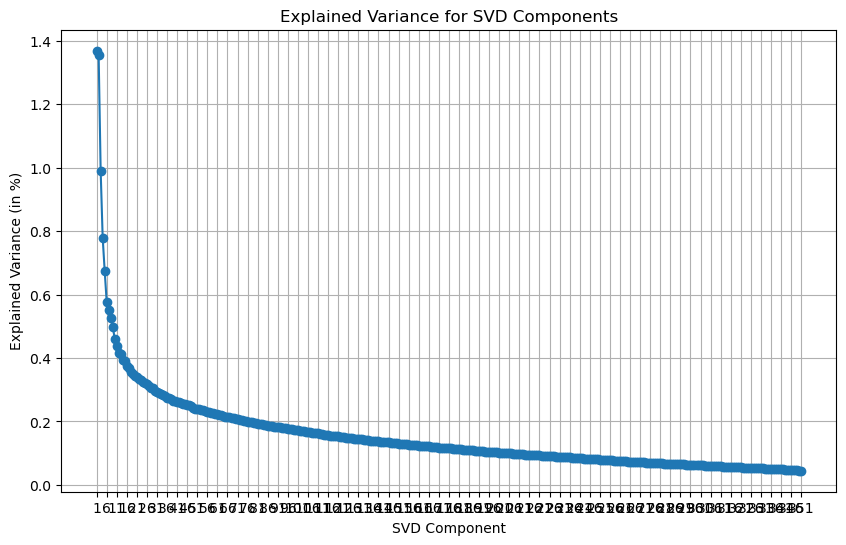

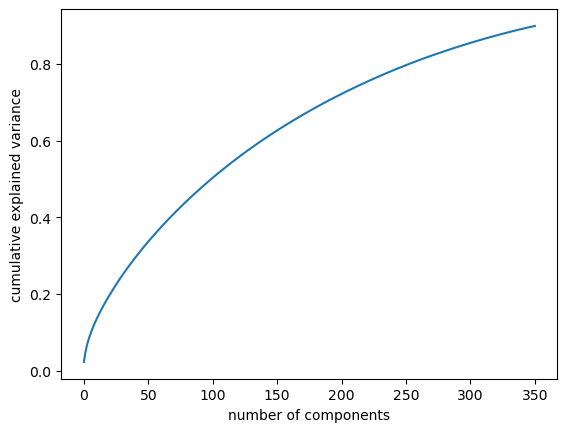

Explained variance of all components summed (%):
89.94209280063072
data shape : (996, 351)
                          foundation         1         2
0               Carlsberg Foundation -0.034772 -0.018408
1  Independent Research Fund Denmark -0.017170 -0.009032
2            Novo Nordisk Foundation  0.047595  0.025124


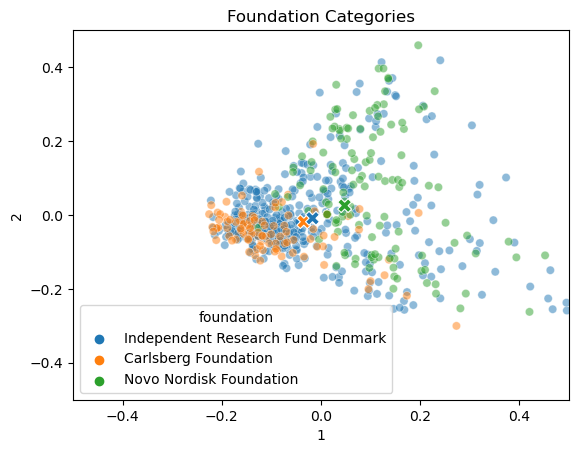

/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1378
['1' '10' '100' ... 'year' 'years' 'young']
shape of dataframe :  (1043, 26)
Year :  2019


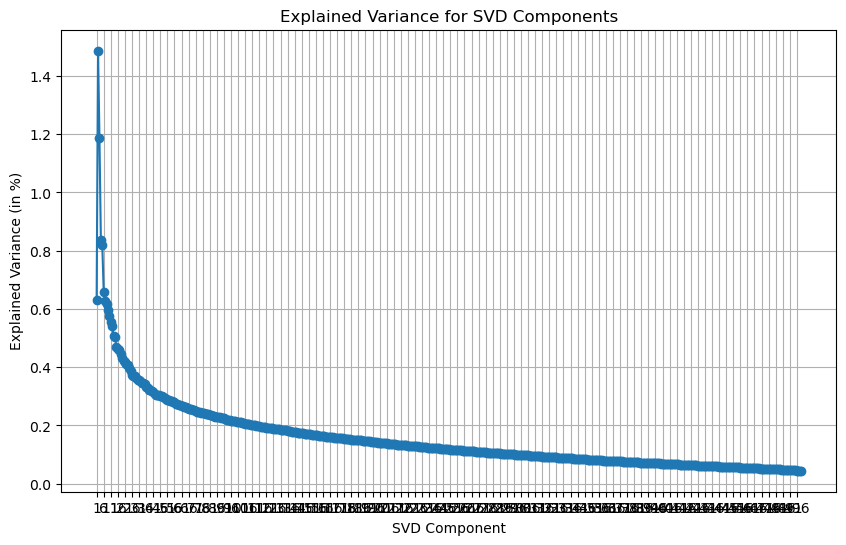

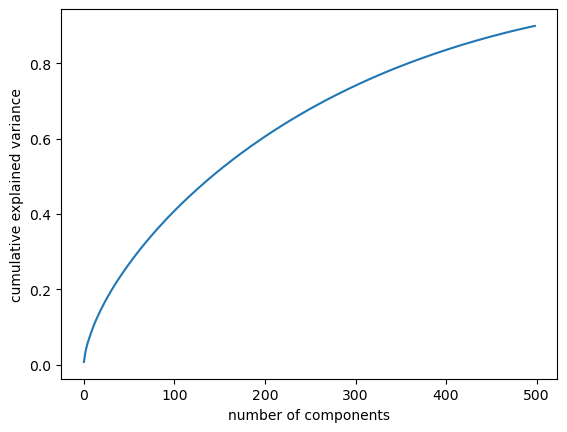

Explained variance of all components summed (%):
89.90813261621447
data shape : (1043, 499)
                          foundation         1         2
0               Carlsberg Foundation -0.070830  0.002677
1  Independent Research Fund Denmark -0.018780 -0.007793
2            Novo Nordisk Foundation  0.075411  0.006233


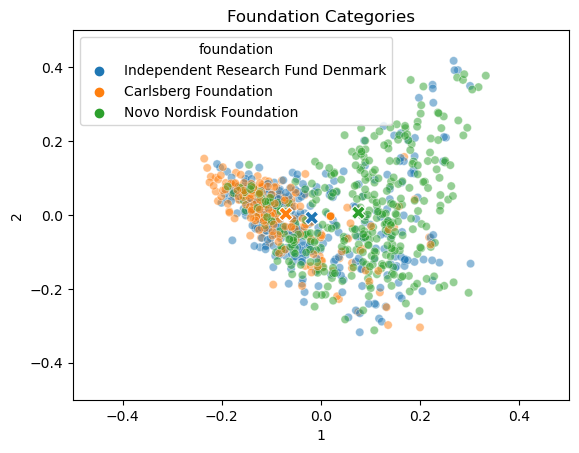

/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1415
['1' '10' '100' ... 'years' 'yield' 'young']
shape of dataframe :  (1200, 26)
Year :  2020


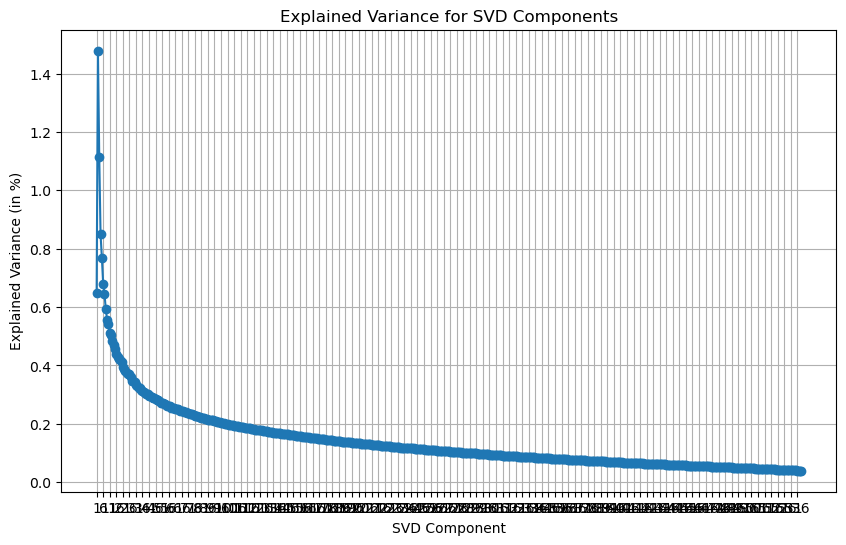

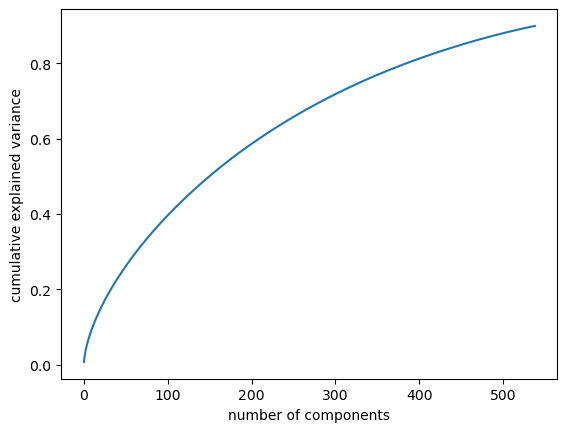

Explained variance of all components summed (%):
89.87444941344035
data shape : (1200, 539)
                          foundation         1         2
0               Carlsberg Foundation -0.062034 -0.006069
1  Independent Research Fund Denmark -0.014179 -0.004521
2            Novo Nordisk Foundation  0.053149  0.008347


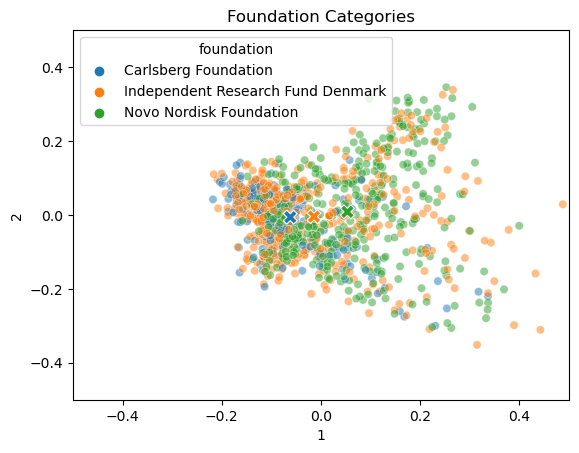

/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1424
['1' '10' '100' ... 'years' 'yield' 'young']
shape of dataframe :  (1247, 26)
Year :  2021


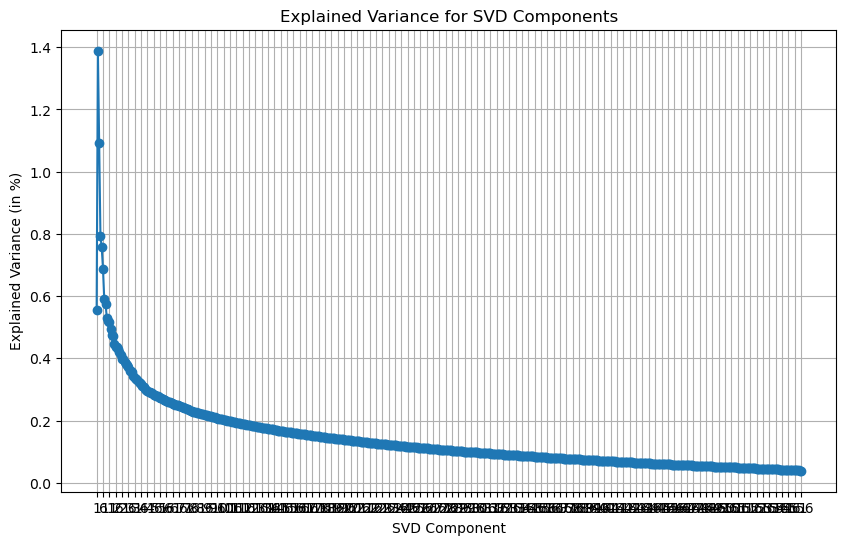

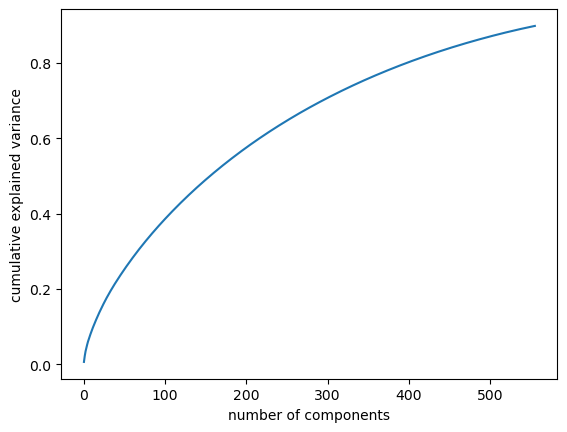

Explained variance of all components summed (%):
89.87872346308635
data shape : (1247, 556)
                          foundation         1         2
0               Carlsberg Foundation -0.063845 -0.005996
1  Independent Research Fund Denmark -0.008923  0.003233
2            Novo Nordisk Foundation  0.058115  0.001556


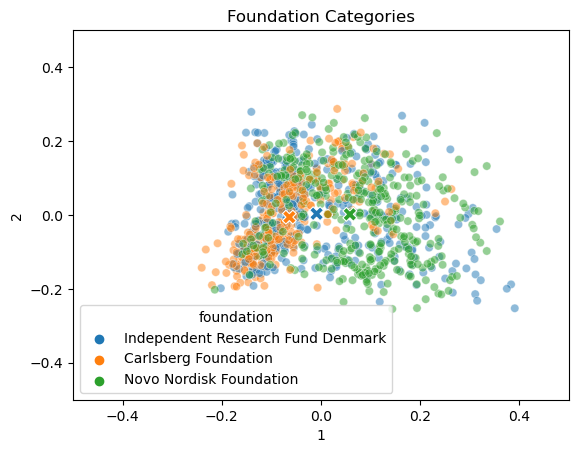

/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1301
['1' '10' '100' ... 'year' 'years' 'young']
shape of dataframe :  (1341, 26)
Year :  2022


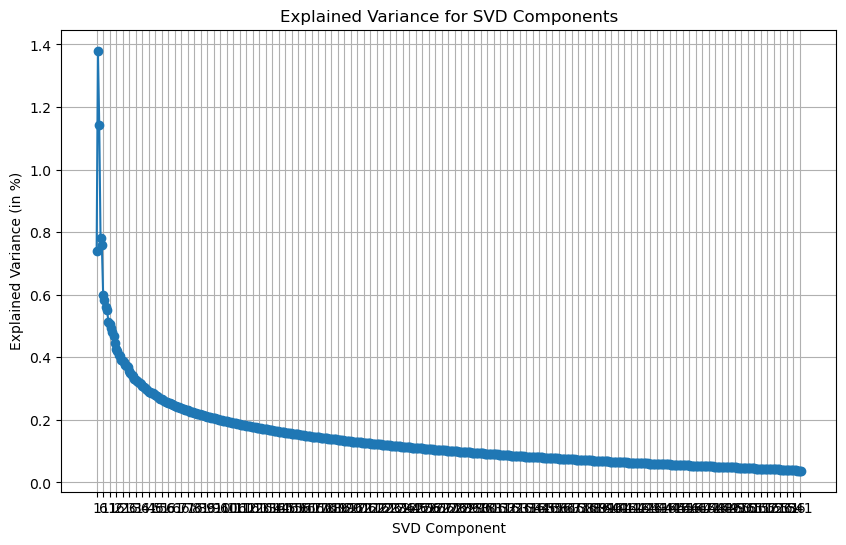

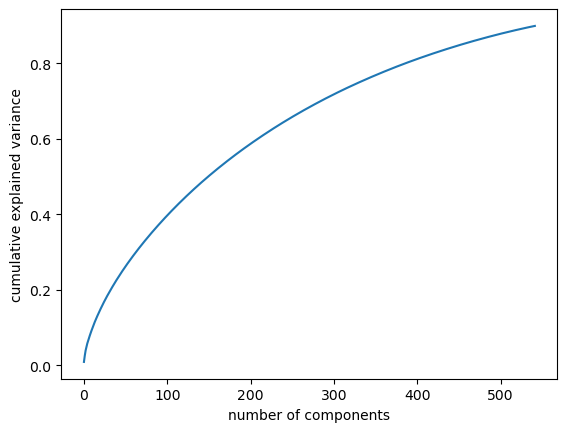

Explained variance of all components summed (%):
89.9019494874737
data shape : (1341, 542)
                          foundation         1         2
0               Carlsberg Foundation -0.082337 -0.003473
1  Independent Research Fund Denmark  0.012033 -0.008042
2            Novo Nordisk Foundation  0.031323  0.007921


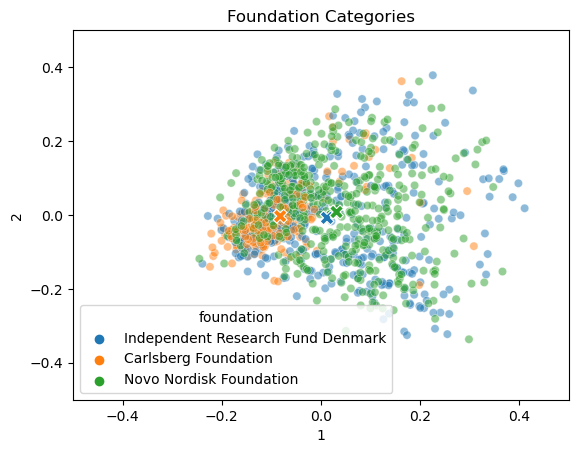

/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1251
['1' '10' '12' ... 'year' 'years' 'young']
shape of dataframe :  (1437, 26)
Year :  2023


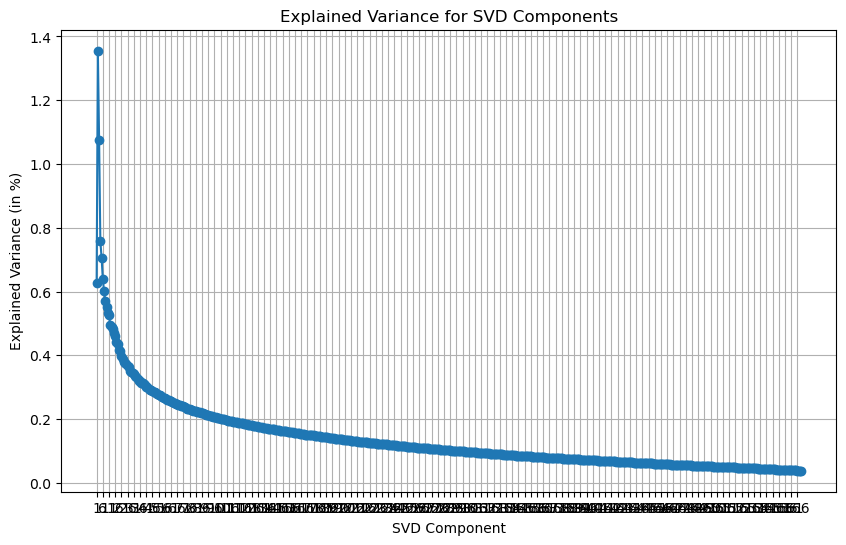

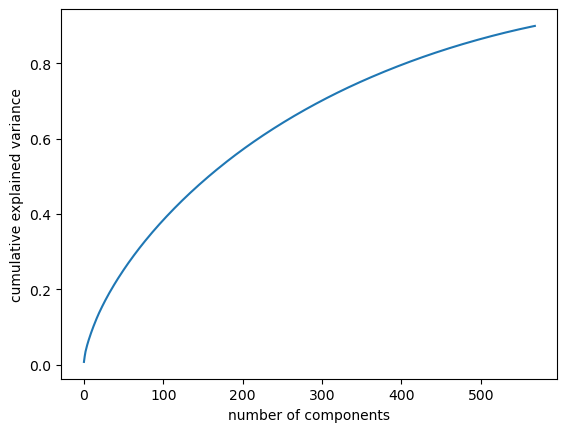

Explained variance of all components summed (%):
89.91032028882296
data shape : (1437, 569)
                          foundation         1         2
0               Carlsberg Foundation -0.067632 -0.018376
1  Independent Research Fund Denmark  0.013528 -0.017073
2            Novo Nordisk Foundation  0.030071  0.029034


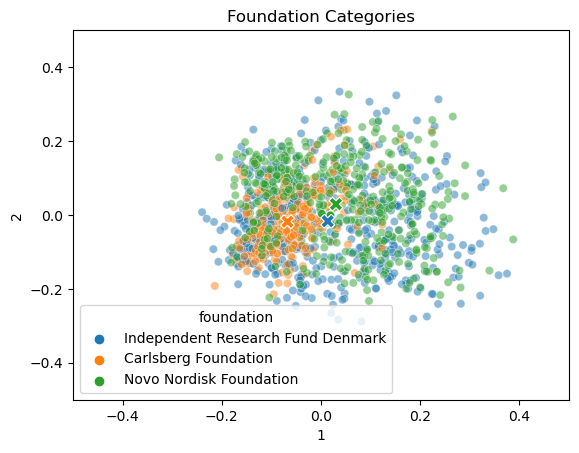

Version 2


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1260
['1' '10' '100' ... 'year' 'years' 'young']
[(1066, 2061), (2062, 3104), (3105, 4304), (4305, 5551), (5552, 6892), (6893, 8329)]


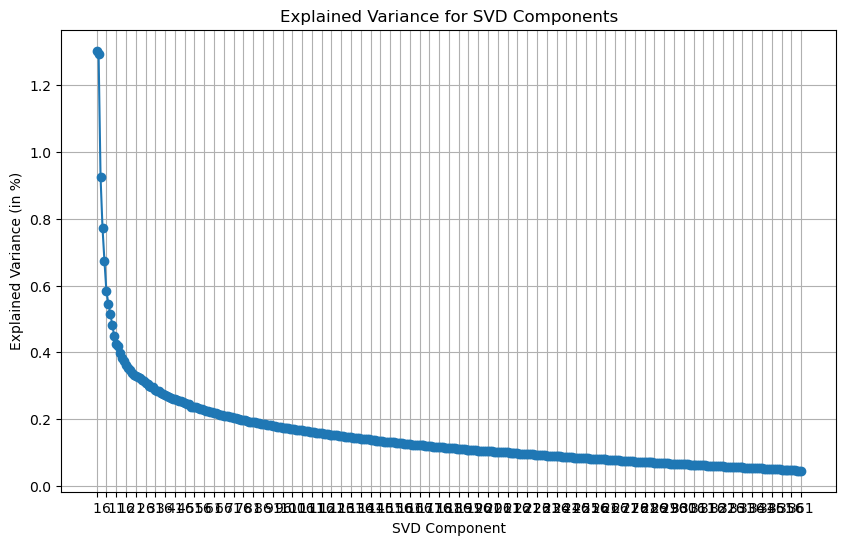

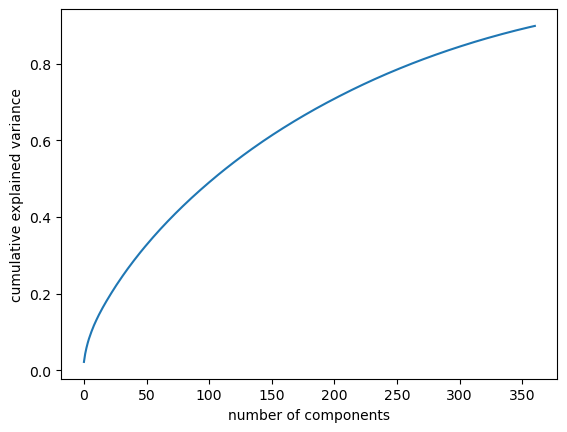

Explained variance of all components summed (%):
89.89530598869887
data shape : (995, 361)


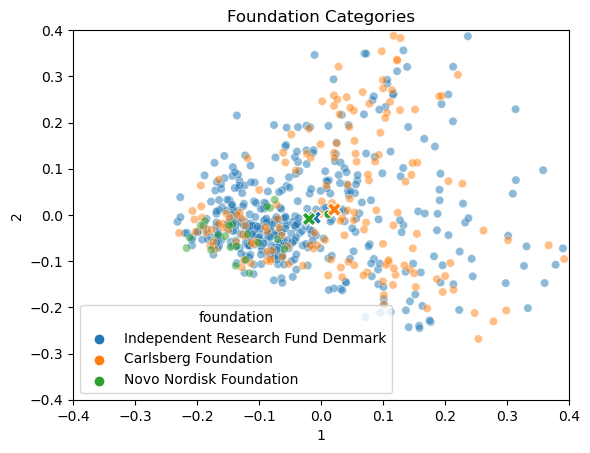

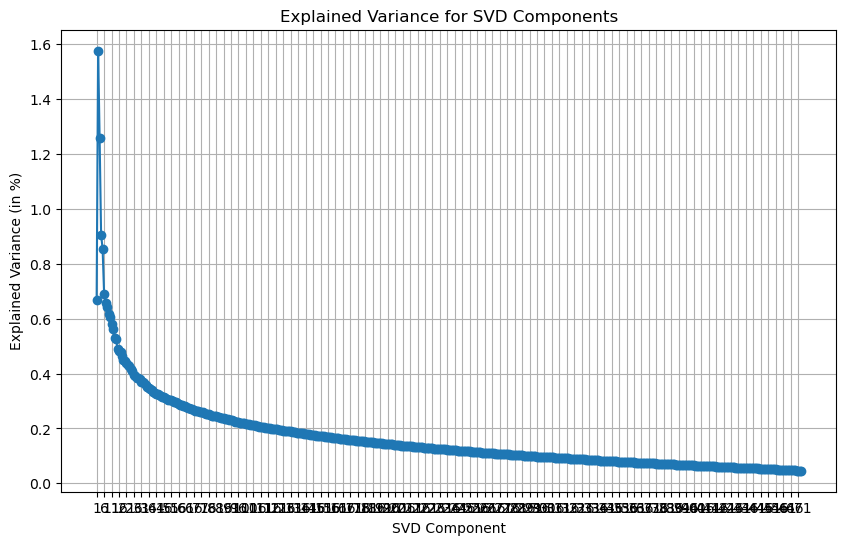

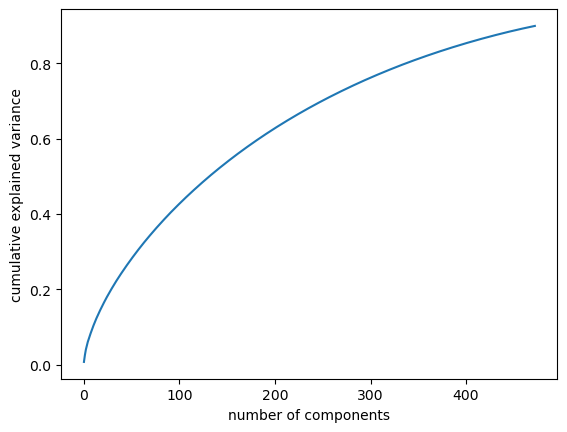

Explained variance of all components summed (%):
89.88577502216557
data shape : (1042, 473)


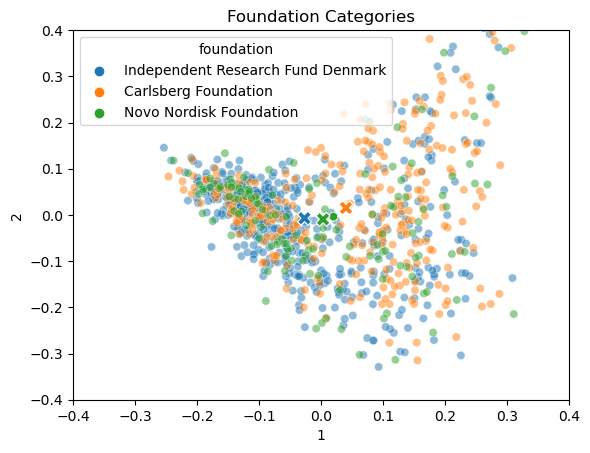

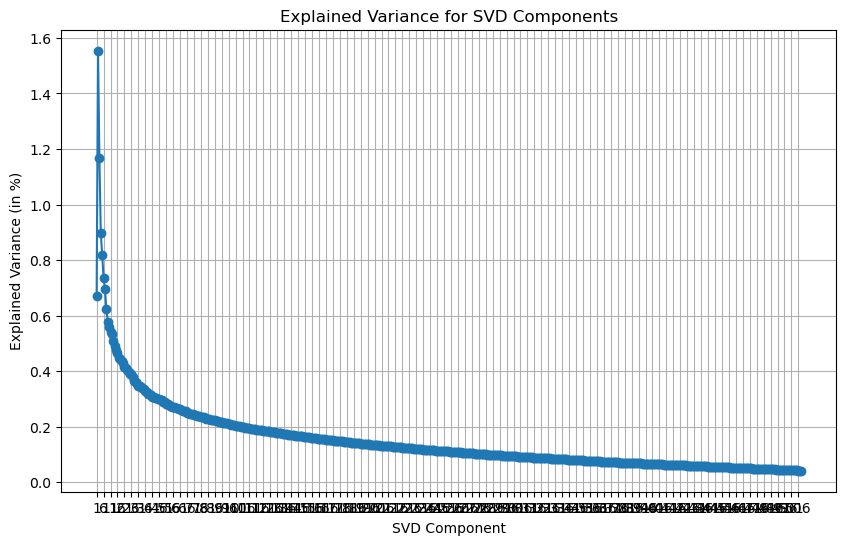

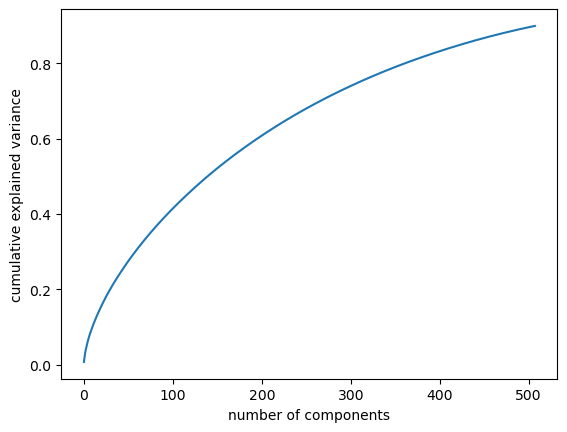

Explained variance of all components summed (%):
89.88814188072887
data shape : (1199, 508)


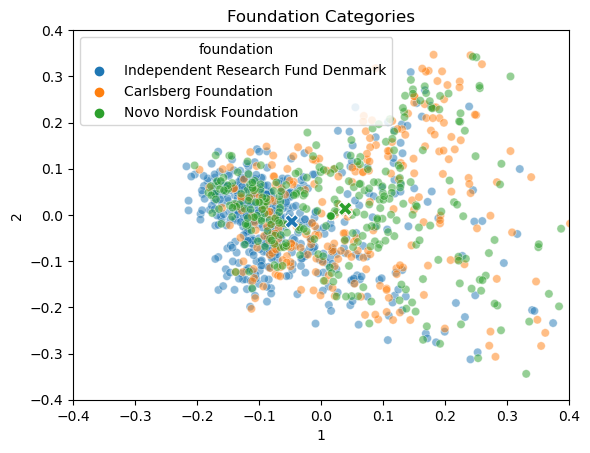

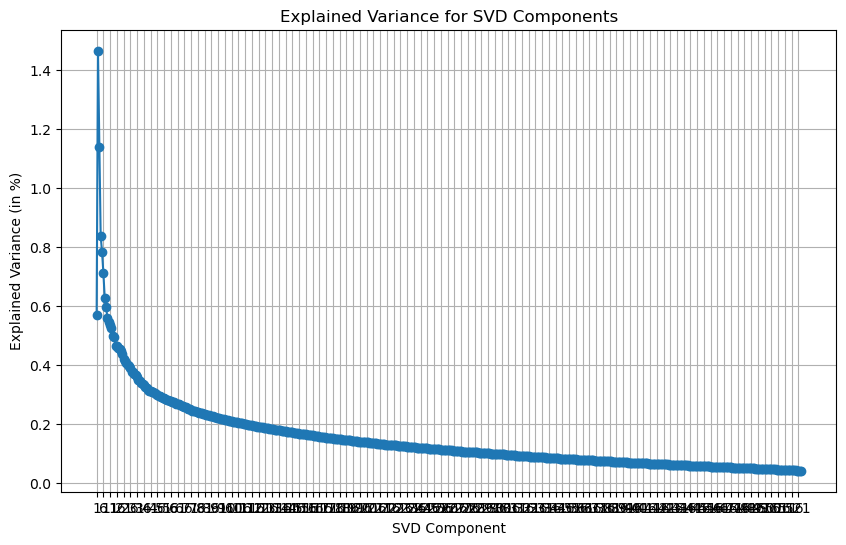

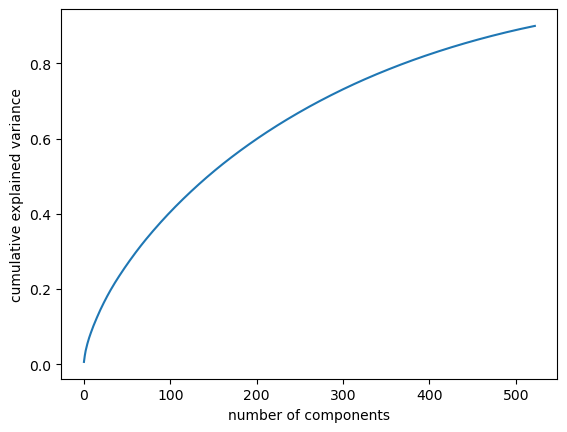

Explained variance of all components summed (%):
89.92114007487491
data shape : (1246, 523)


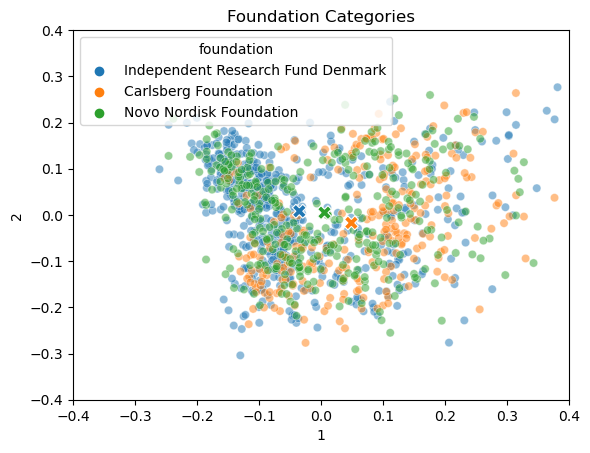

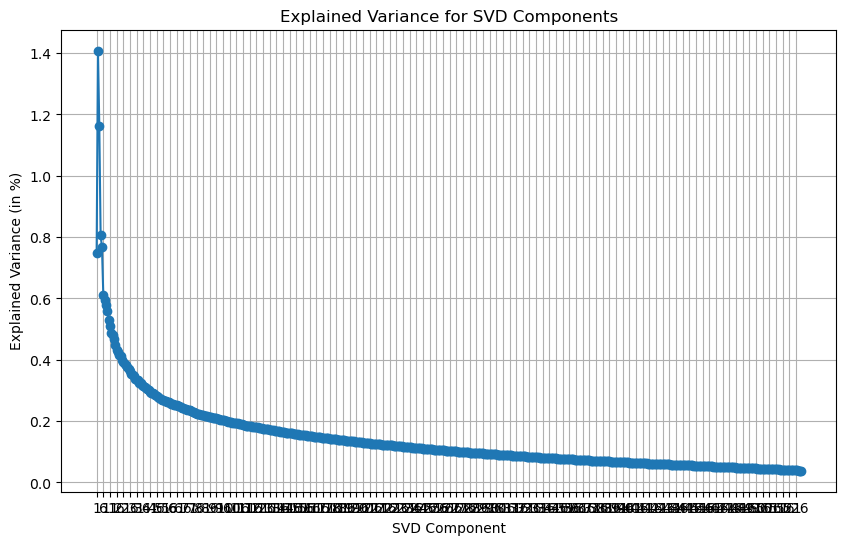

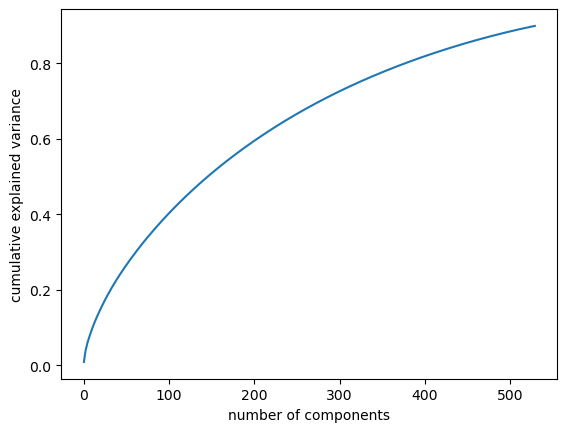

Explained variance of all components summed (%):
89.92839546239307
data shape : (1340, 530)


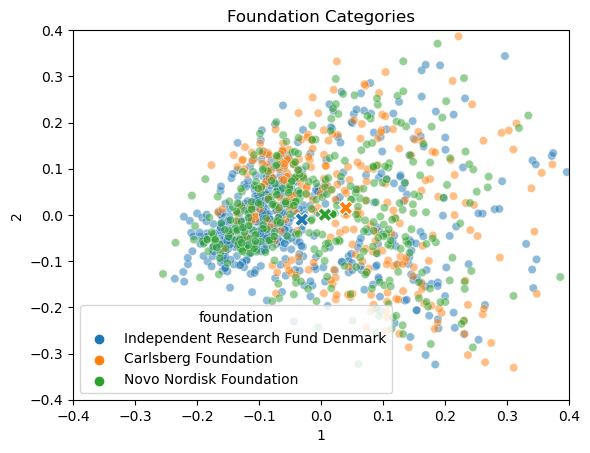

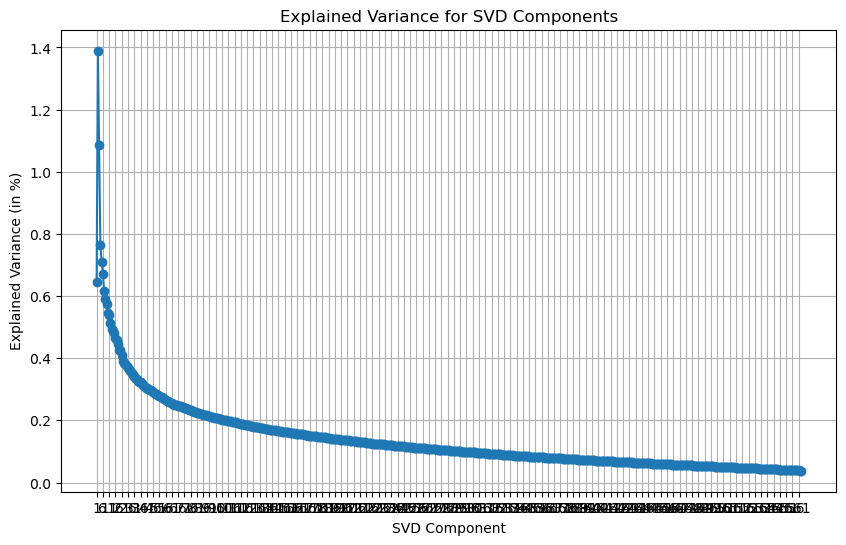

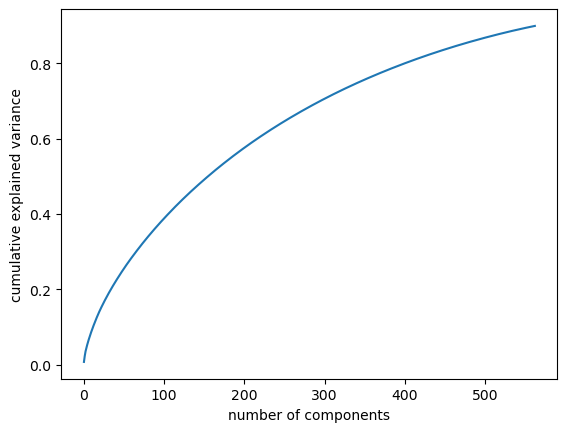

Explained variance of all components summed (%):
89.92625702424972
data shape : (1436, 563)


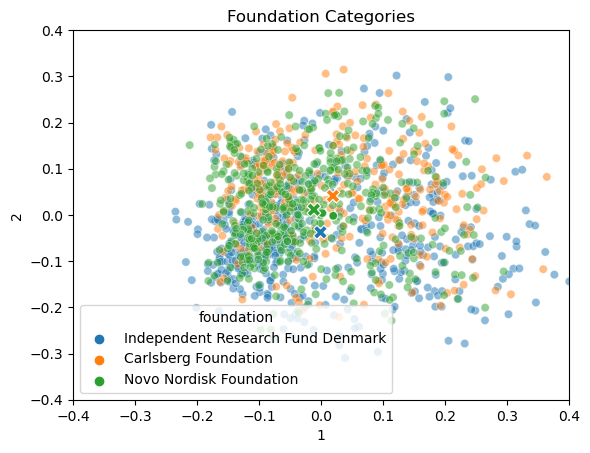

In [29]:

#calling 1

df_clean["abstract_no_nan"] = df_clean.cleaned_column.fillna('')

print("Version 1")
fun_call_v1(df_clean) #version 1 -> reset every year, calculate TF-IDF individual for each year

print("Version 2")
fun_call_v2(df_clean) #version 2 -> make tf_idf with all data and then iterate over the years 

Version 1


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1131
['1' '10' '100' ... 'year' 'years' 'young']
shape of dataframe :  (996, 26)
Year :  2018


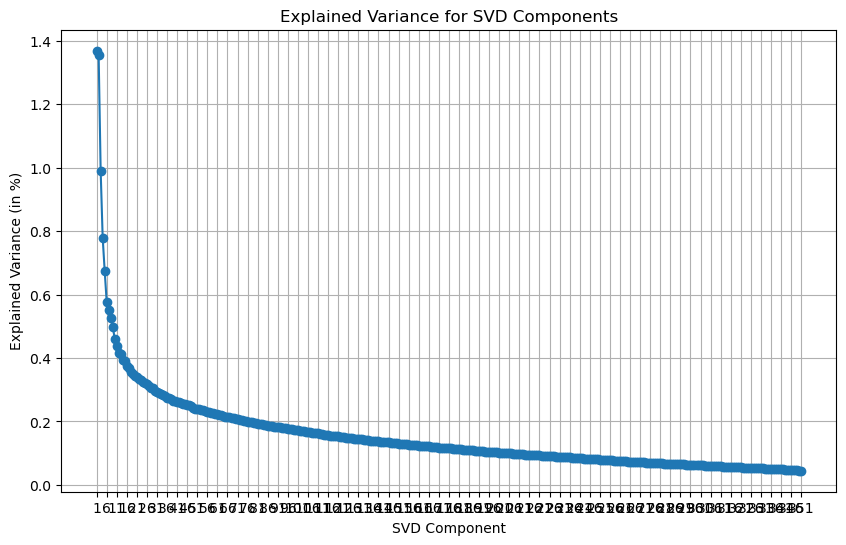

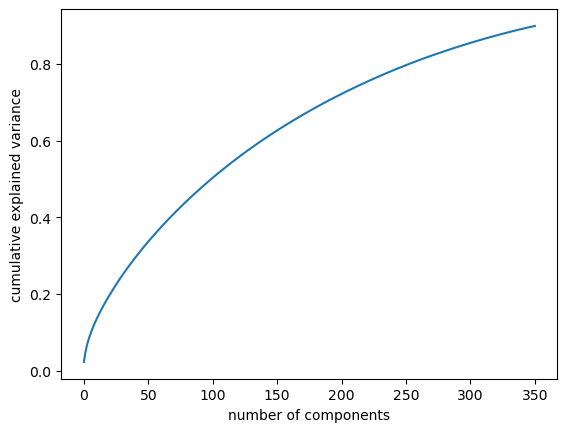

Explained variance of all components summed (%):
89.94209280063072
data shape : (996, 351)
                          foundation         1         2
0               Carlsberg Foundation -0.047033 -0.019981
1  Independent Research Fund Denmark -0.029431 -0.010605
2            Novo Nordisk Foundation  0.035334  0.023551


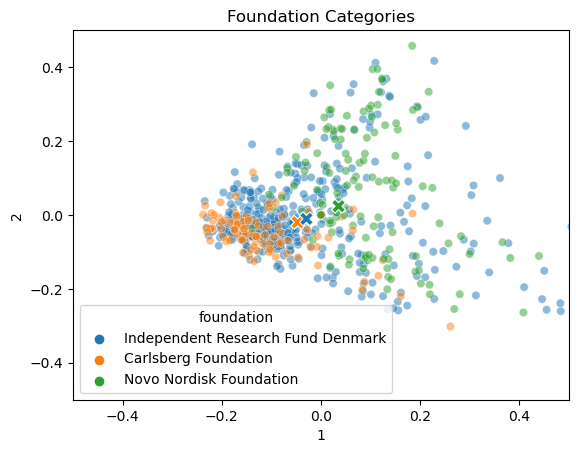

/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1378
['1' '10' '100' ... 'year' 'years' 'young']
shape of dataframe :  (1043, 26)
Year :  2019


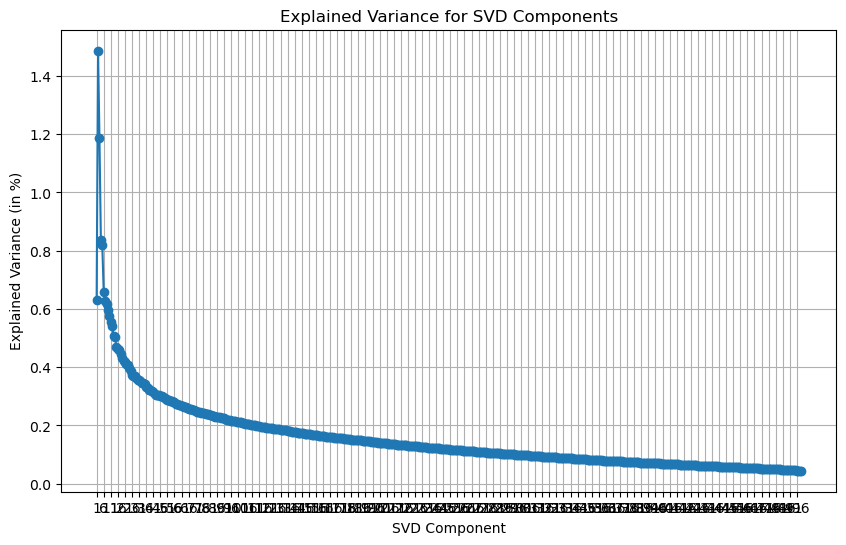

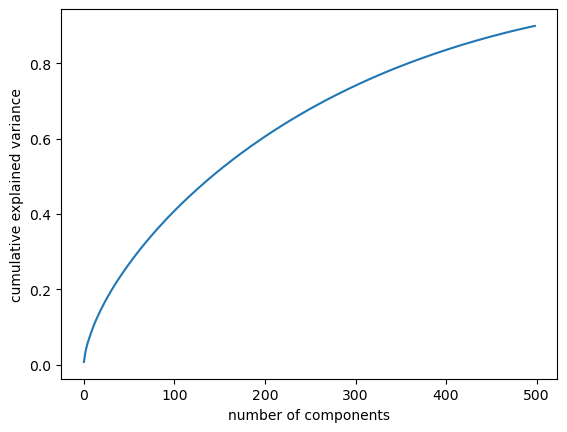

Explained variance of all components summed (%):
89.90813261621447
data shape : (1043, 499)
                          foundation         1         2
0               Carlsberg Foundation -0.090115  0.006186
1  Independent Research Fund Denmark -0.038065 -0.004284
2            Novo Nordisk Foundation  0.056126  0.009742


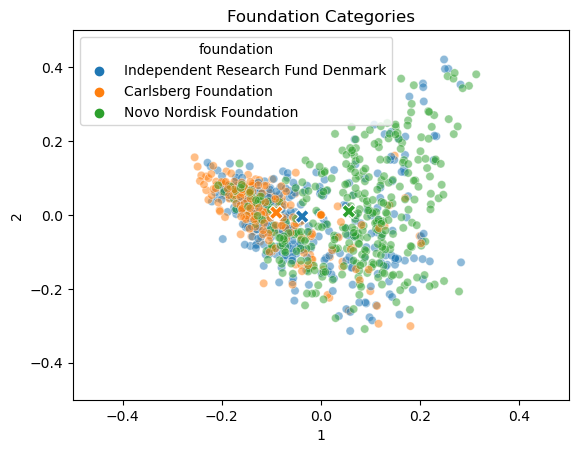

/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1415
['1' '10' '100' ... 'years' 'yield' 'young']
shape of dataframe :  (1200, 26)
Year :  2020


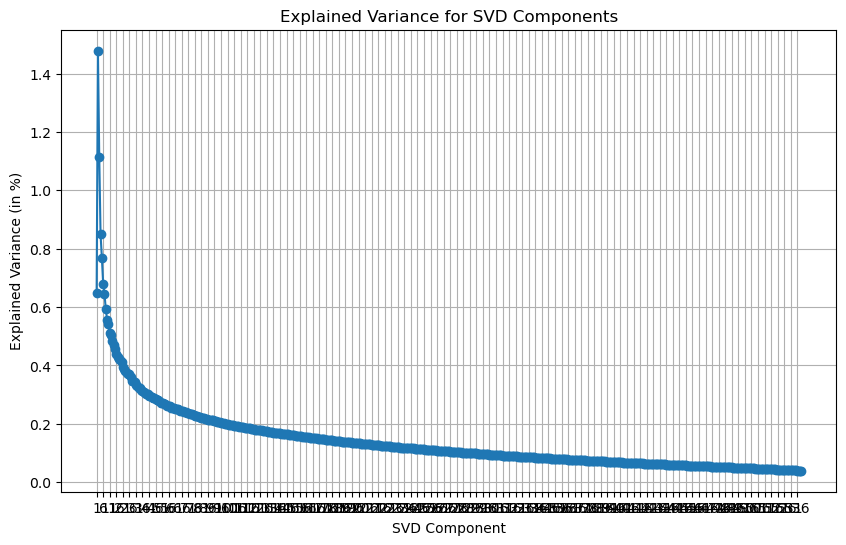

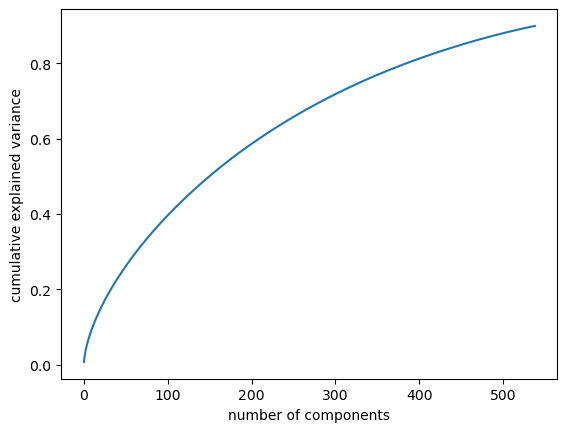

Explained variance of all components summed (%):
89.87444941344035
data shape : (1200, 539)
                          foundation         1         2
0               Carlsberg Foundation -0.078643 -0.003993
1  Independent Research Fund Denmark -0.030789 -0.002445
2            Novo Nordisk Foundation  0.036539  0.010423


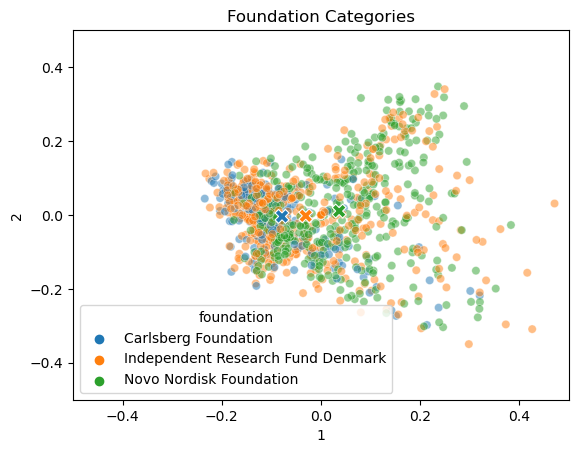

/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1424
['1' '10' '100' ... 'years' 'yield' 'young']
shape of dataframe :  (1247, 26)
Year :  2021


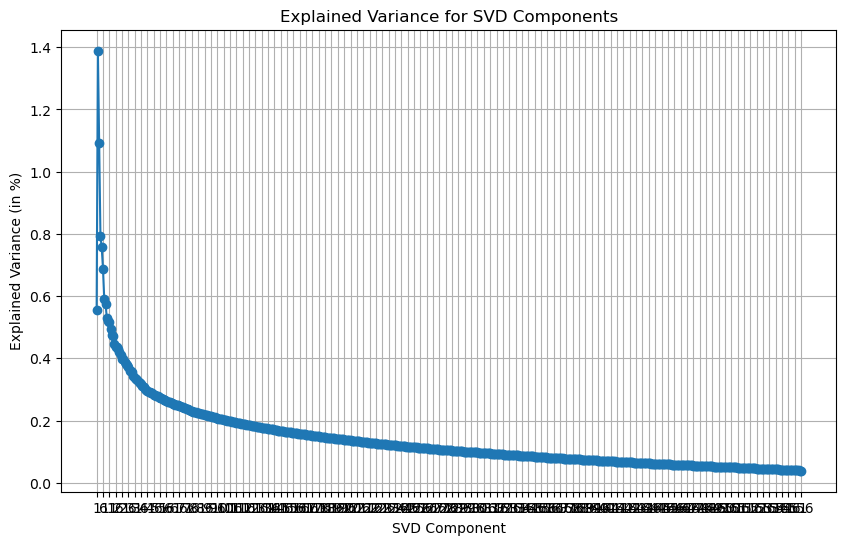

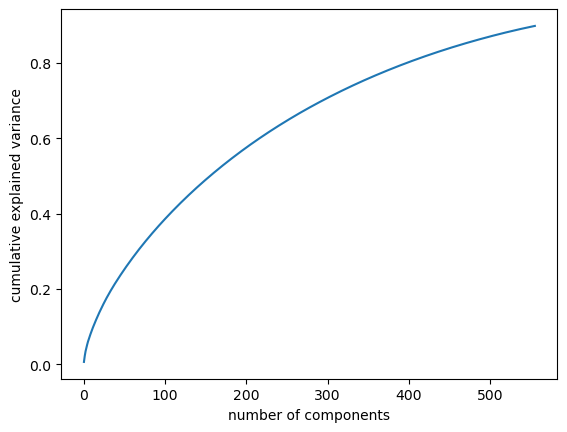

Explained variance of all components summed (%):
89.87872346308635
data shape : (1247, 556)
                          foundation         1         2
0               Carlsberg Foundation -0.077759 -0.007815
1  Independent Research Fund Denmark -0.022838  0.001415
2            Novo Nordisk Foundation  0.044200 -0.000262


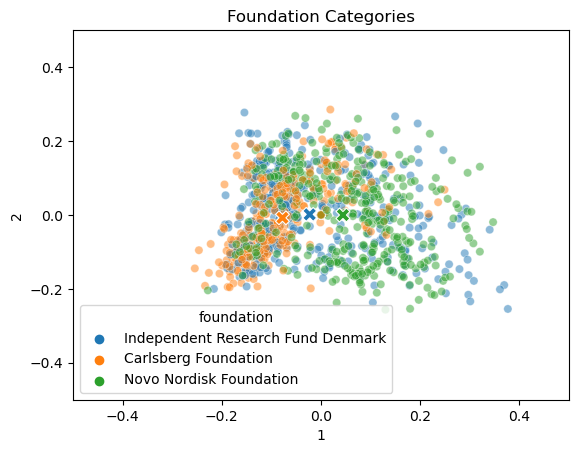

/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1301
['1' '10' '100' ... 'year' 'years' 'young']
shape of dataframe :  (1341, 26)
Year :  2022


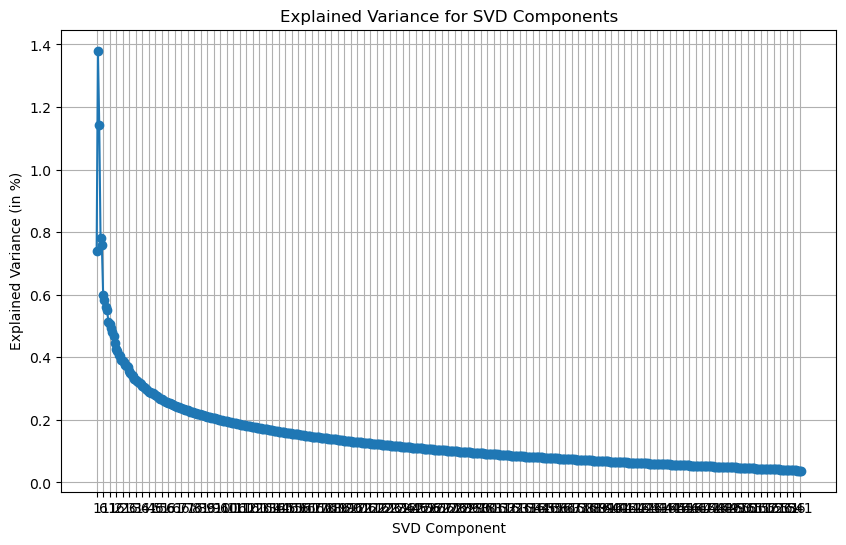

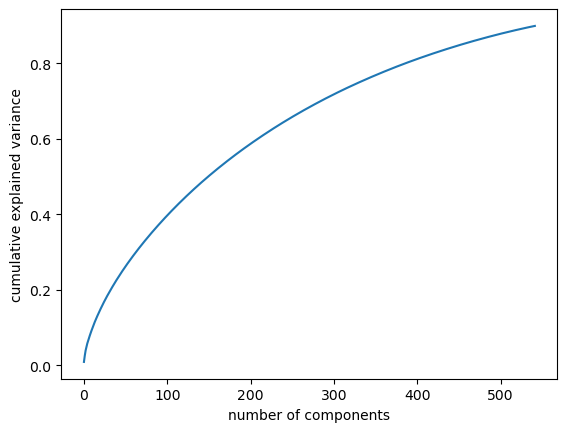

Explained variance of all components summed (%):
89.9019494874737
data shape : (1341, 542)
                          foundation         1         2
0               Carlsberg Foundation -0.101101 -0.005414
1  Independent Research Fund Denmark -0.006731 -0.009984
2            Novo Nordisk Foundation  0.012560  0.005980


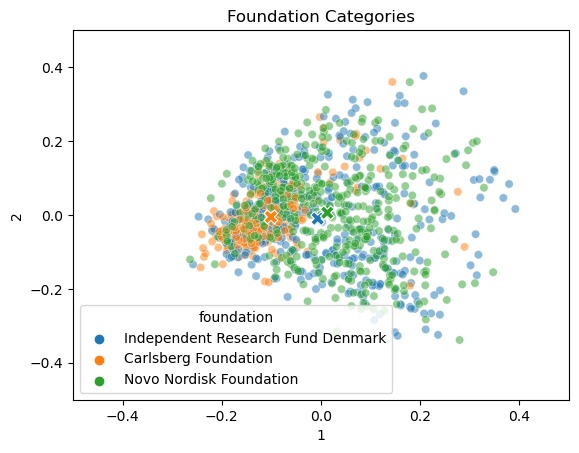

/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1251
['1' '10' '12' ... 'year' 'years' 'young']
shape of dataframe :  (1437, 26)
Year :  2023


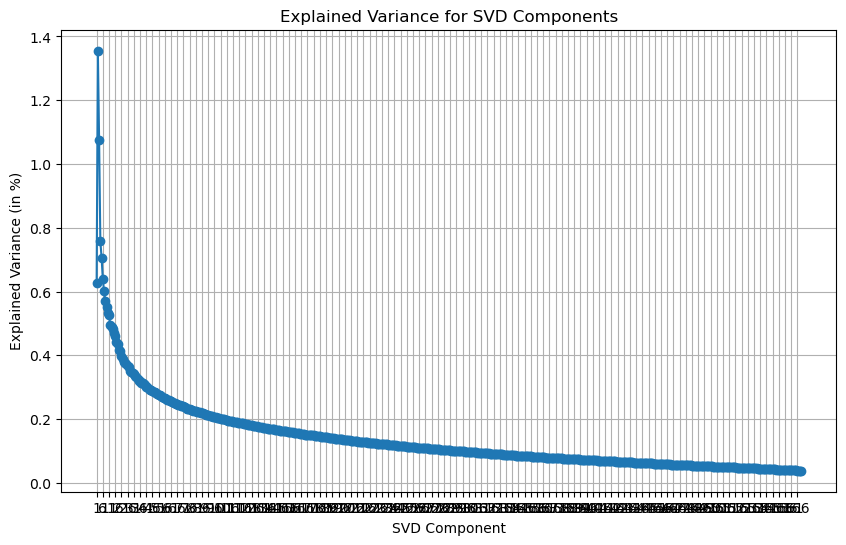

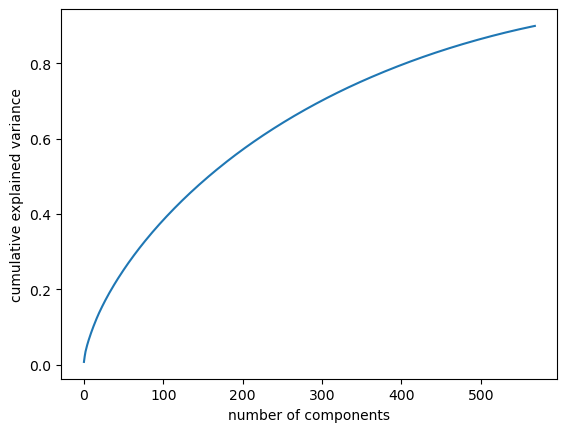

Explained variance of all components summed (%):
89.91032028882296
data shape : (1437, 569)
                          foundation         1         2
0               Carlsberg Foundation -0.086565 -0.017358
1  Independent Research Fund Denmark -0.005405 -0.016054
2            Novo Nordisk Foundation  0.011138  0.030053


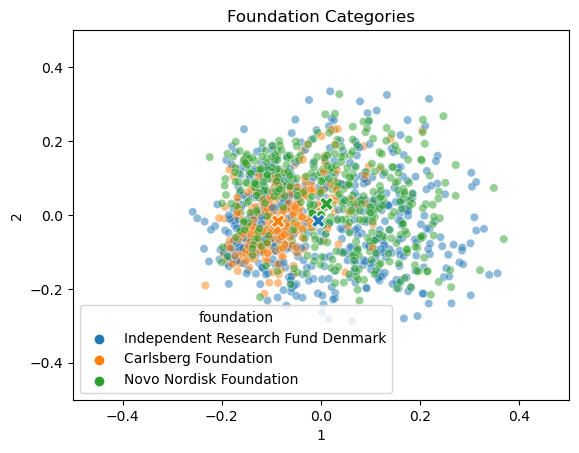

Version 2


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1260
['1' '10' '100' ... 'year' 'years' 'young']
[(1066, 2061), (2062, 3104), (3105, 4304), (4305, 5551), (5552, 6892), (6893, 8329)]


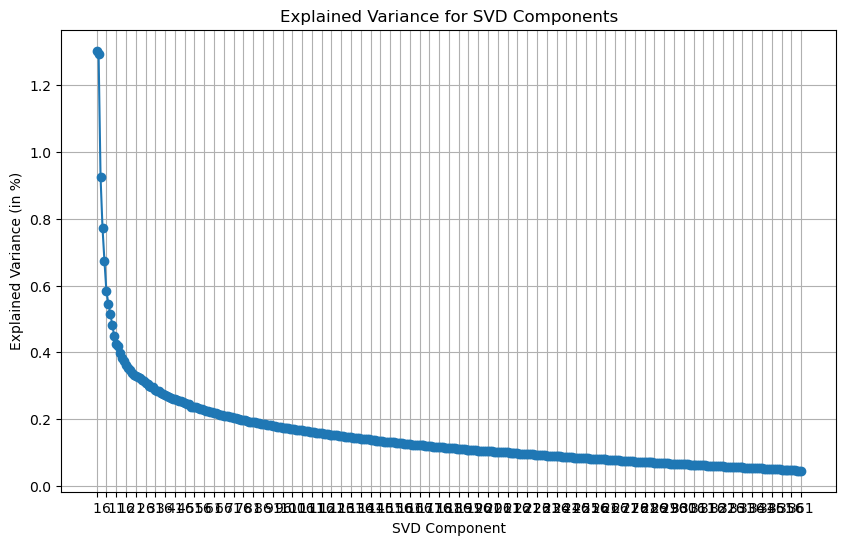

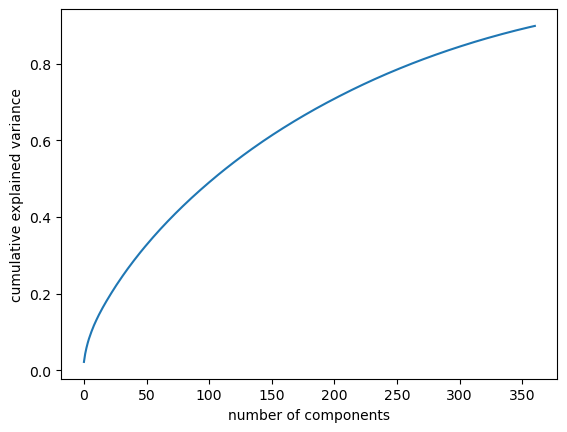

Explained variance of all components summed (%):
89.89530598869887
data shape : (995, 361)


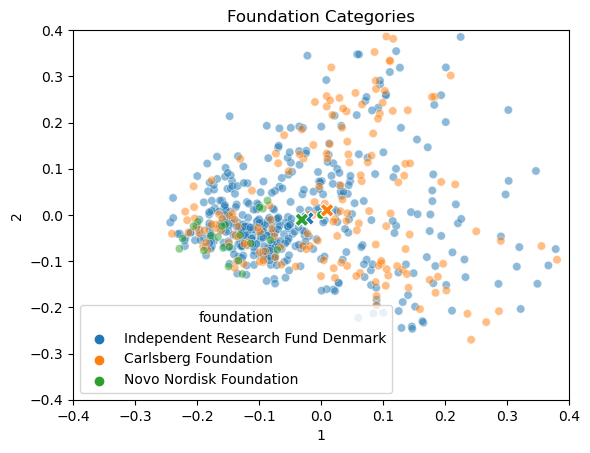

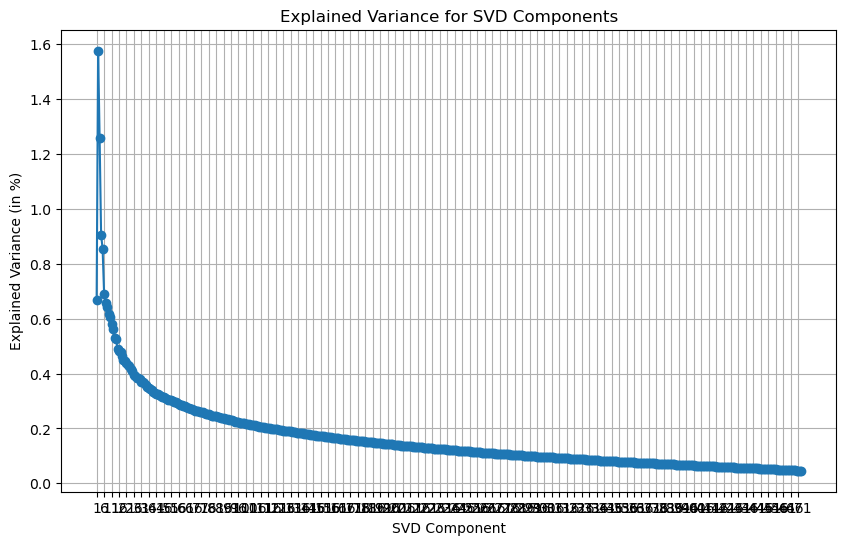

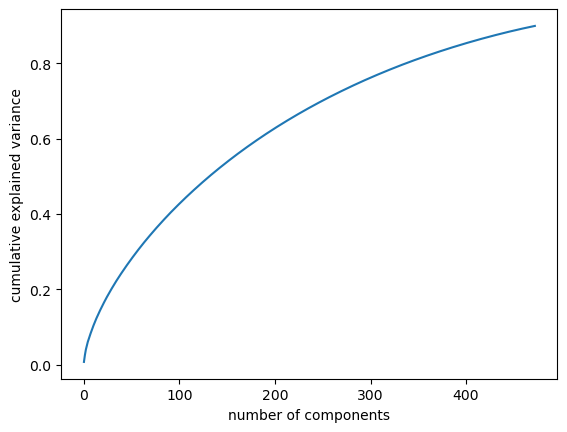

Explained variance of all components summed (%):
89.88577502216557
data shape : (1042, 473)


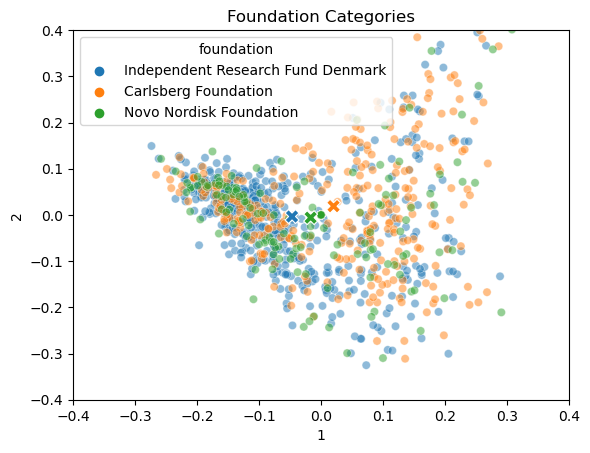

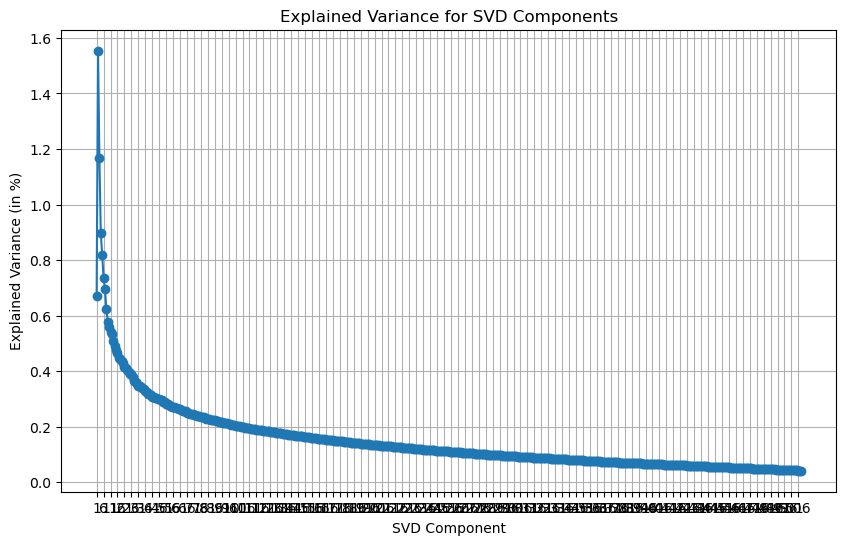

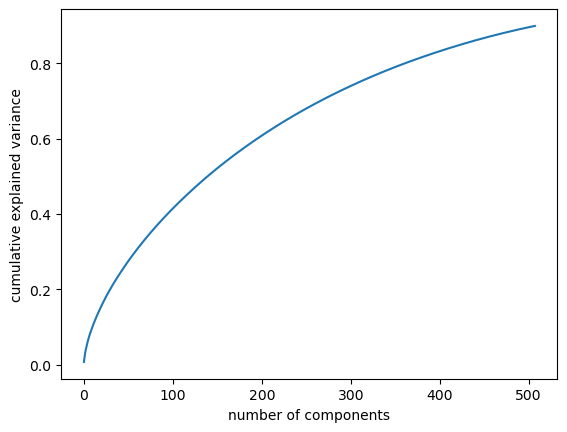

Explained variance of all components summed (%):
89.88814188072887
data shape : (1199, 508)


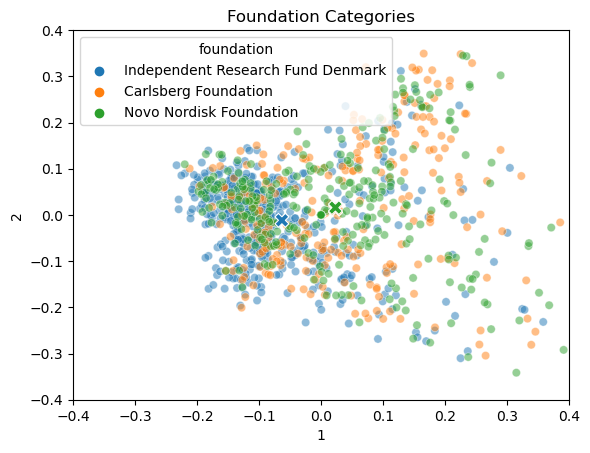

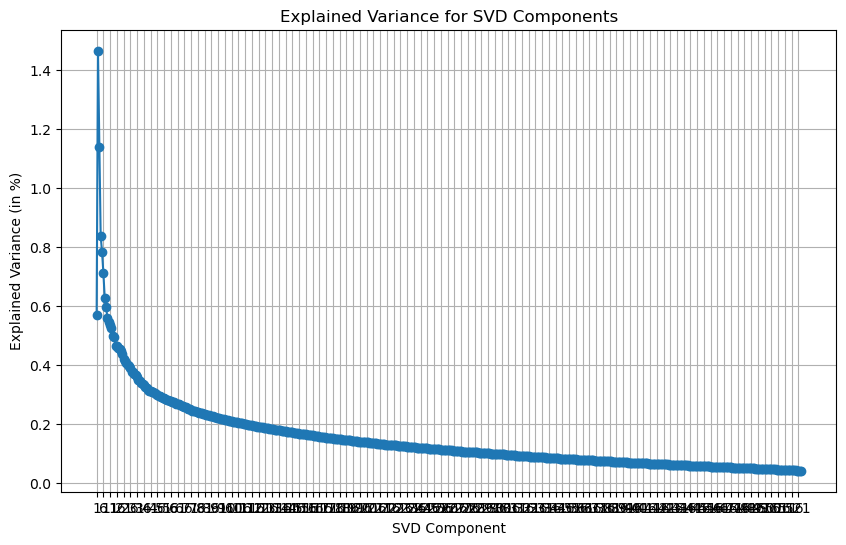

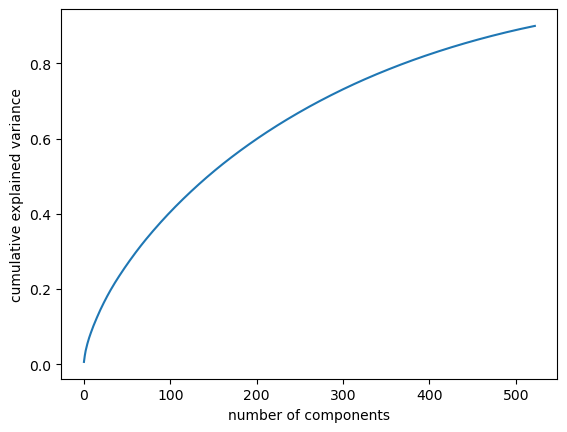

Explained variance of all components summed (%):
89.92114007487491
data shape : (1246, 523)


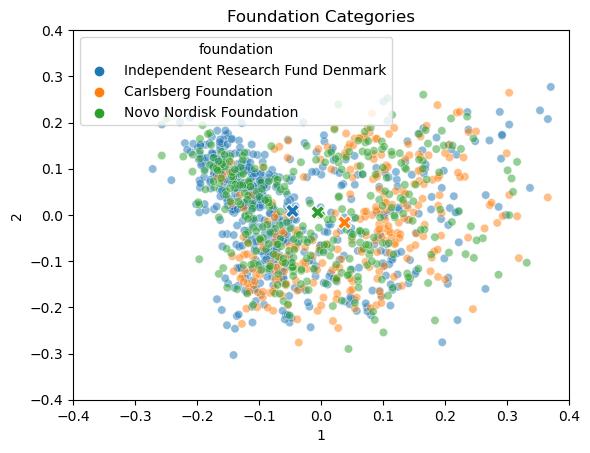

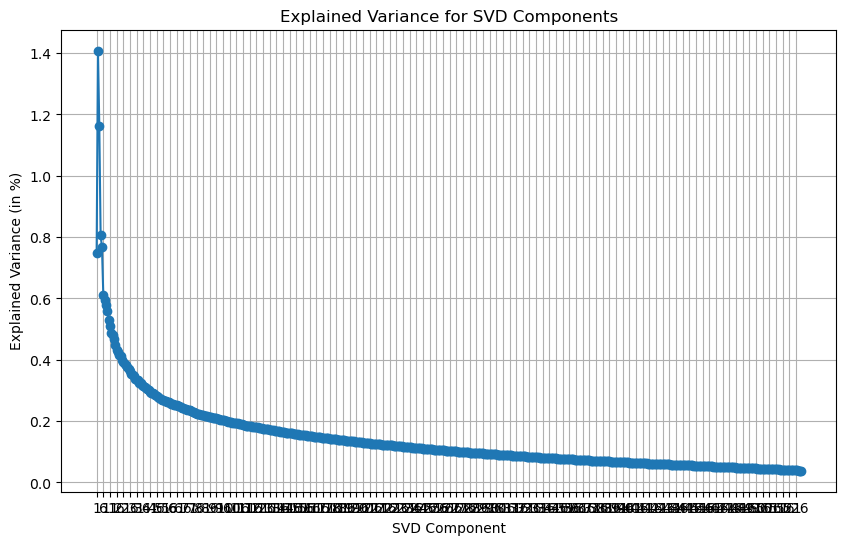

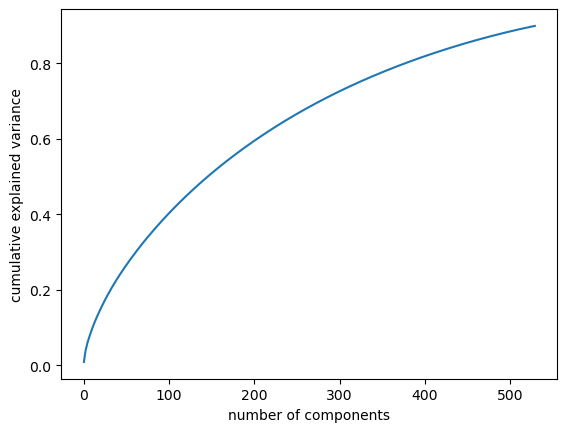

Explained variance of all components summed (%):
89.92839546239307
data shape : (1340, 530)


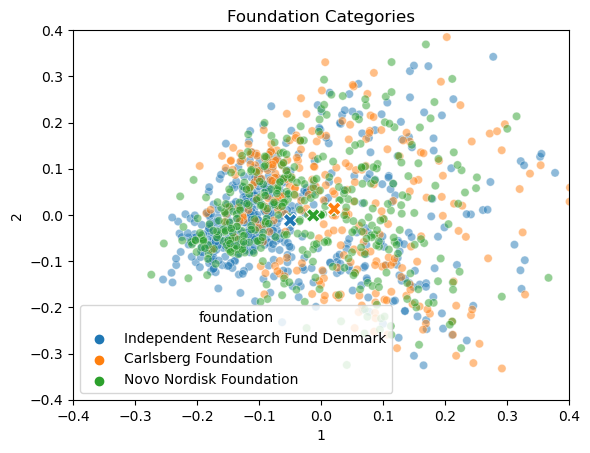

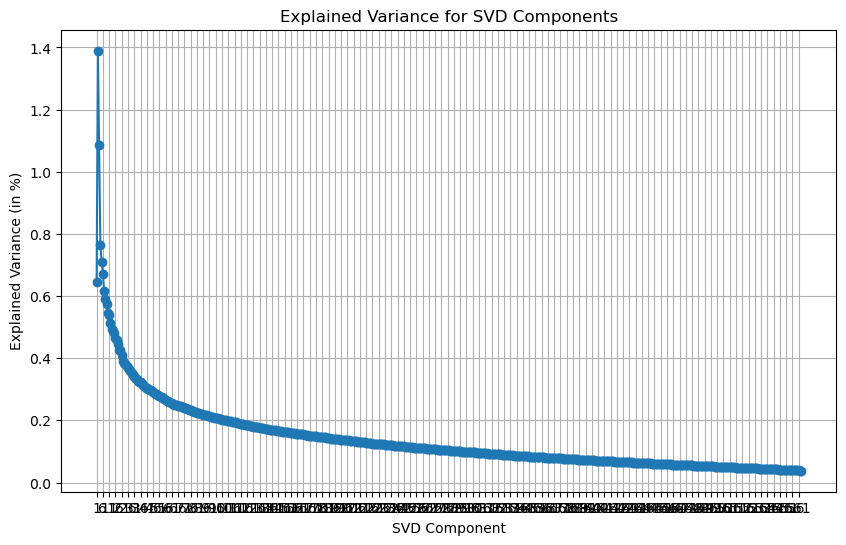

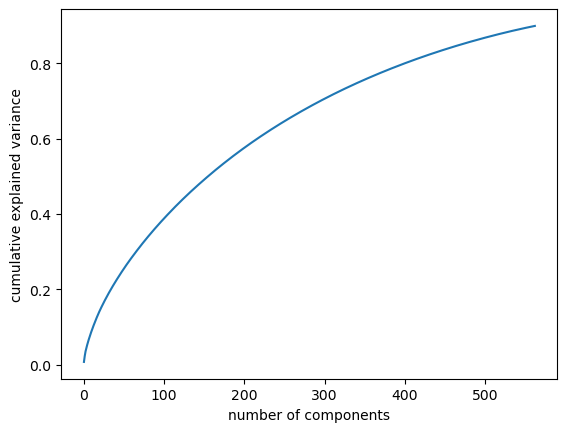

Explained variance of all components summed (%):
89.92625702424972
data shape : (1436, 563)


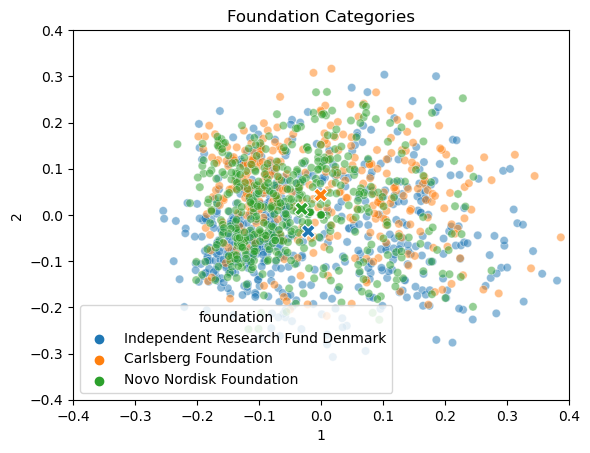

In [25]:
#version - data cleanse with no stemming
df_clean_no_stem["abstract_no_nan"] = df_clean.cleaned_column.fillna('')
print("Version 1")
fun_call_v1(df_clean_no_stem) #version 1 -> reset every year, calculate TF-IDF individual for each year

print("Version 2")
fun_call_v2(df_clean_no_stem)


In [34]:
def tf_idf_dist(df_target_column, min_ins, max_ins):
    
    df_target_column = df_target_column.fillna('')
    
    tf = TfidfVectorizer(tokenizer=casual_tokenize, min_df = min_ins, max_df = max_ins, stop_words='english', norm = "l2") #tf-idf tokenize init
    
    x_vector = tf.fit_transform(df_target_column)  # transform data
    number_of_features = len(tf.get_feature_names_out())
    
    print(number_of_features)
    print(tf.get_feature_names_out())
    
    return x_vector, number_of_features, tf



X_vector, N_features, tf = tf_idf_dist(df_clean_no_stem["abstract_no_nan"], 0.01, 0.9)  #tf_idf function



1260
['1' '10' '100' ... 'year' 'years' 'young']


In [10]:
def tf_idf_fun(df_column):
    """ this function give a takes a dataframe with text samples as input, 
    it vectorizes the words into CountVectorizer() matrix, and then converts that into TF-IDF matrix
    
    return:
    1. Vector with each feature (words) and its TF-IDF value
    2. TF-IDF vector
    3. CV vector
    
    """
    df_column = df_column.dropna()
    cv=CountVectorizer()
    cv_vec=cv.fit_transform(df_column) #transformation
    print(cv_vec.shape)
    
    cv_df = pd.DataFrame(data= cv_vec.toarray(), columns = cv.get_feature_names_out())
    
    tf_transform=TfidfTransformer(smooth_idf=True,use_idf=True) #tfidf instansiating
    tfidfvec = tf_transform.fit(cv_vec) #Transforming a count matrix into a tf-idf format
    idf_data = pd.DataFrame(tf_transform.idf_, index=cv.get_feature_names_out(),columns=["tfidf_values"]) #computing the IDF values
    result_tfidf = idf_data.sort_values(by=['tfidf_values']) #sorting by idf value 
    return cv_vec, tfidfvec, result_tfidf

In [11]:
"""

tf_idf_fun(df_use["a_no_nan"])


tf = TfidfVectorizer()
X = tf.fit_transform(df_use["a_no_nan"])

X

feature_names = tf.get_feature_names_out()
dense = X.todense()
denselist = dense.tolist()
df2 = pd.DataFrame(denselist, columns=feature_names)

print(df2)
"""

NameError: name 'df_use' is not defined

In [ ]:
tf_idf_fun(df_use["a_no_nan"])

In [ ]:
# TF-IDF to remove words in the middle - 3 documents 

# consider removing verbs and adjective 

# mapping word specificity to each foundation 


#PCA of the TF-IDF vector matrix

#find a way to score a grant vectors score 

#cosine similarity -> eucledian distance 


In [ ]:
#1!!!

#1 Sparse matrix -> dense matrix representation 

# 1. tf_idf conversion 2024_ref + target_1
# 2. Take mean of tf_idf_matrix 2024_ref's -> 24ref_vector 
# 3. calculate cosine similarity between 24ref_vector + target_1

#2. Combine all ref and target vectors and do tf-IDF across all documents 

# 1. take mean of ref vectors 
# 3. calculate cosine similarity between 24ref_vector and iterate over each target_i and compare


#3. yearwise iteration 

# include and compare the 5 most important words between years 


